In [1]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [2]:
print (librosa.__version__)

0.5.1


In [3]:
#set FIXED variables
#HOMEPATH = "/home/ubuntu/fastai/"
DATATPATH = "/home/ubuntu/fastai/data/urbanSound8k/"

In [10]:
#save features & labels to file, enable restart from pre-compiled position.
os.chdir(DATATPATH)
print (DATATPATH)
print ("current working directory:", os.getcwd())

features = pickle.load( open(DATATPATH+"features.p", "rb" ) )
print ("features:", type(features), features.shape)
labels   = pickle.load( open(DATATPATH+"labels.p", "rb" ) )
print ("labels:", type(labels), labels.shape)

/home/ubuntu/fastai/data/urbanSound8k/
current working directory: /home/ubuntu/fastai/data/urbanSound8k
features: <class 'numpy.ndarray'> (10834, 60, 41, 2)
labels: <class 'numpy.ndarray'> (10834, 10)


In [11]:
print ("features:", type(features), features.shape)
print ("labels:", type(labels), labels.shape)

features: <class 'numpy.ndarray'> (10834, 60, 41, 2)
labels: <class 'numpy.ndarray'> (10834, 10)


In [35]:
features[0].shape

(60, 41, 2)

In [34]:
labels[0]

array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [12]:
os.getcwd()

'/home/ubuntu/fastai/data/urbanSound8k'

In [13]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(1.0, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x,W,strides=[1,2,2,1], padding='SAME')

def apply_convolution(x,kernel_size,num_channels,depth):
    weights = weight_variable([kernel_size, kernel_size, num_channels, depth])
    biases = bias_variable([depth])
    return tf.nn.relu(tf.add(conv2d(x, weights),biases))

def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, kernel_size, kernel_size, 1], 
                          strides=[1, stride_size, stride_size, 1], padding='SAME')

In [21]:
rnd_indices = np.random.rand(len(labels)) < 0.70

train_x = features[rnd_indices]
train_y = labels[rnd_indices]
test_x = features[~rnd_indices]
test_y = labels[~rnd_indices]

print (len(labels))
print (type(rnd_indices), rnd_indices.shape)

print ("train_x:", train_x.shape)
print ("train_y:", train_y.shape)
print ("test_x:", test_x.shape)
print ("test_y:", test_y.shape)
print (train_y.shape[0]+test_x.shape[0])

10834
<class 'numpy.ndarray'> (10834,)
train_x: (7529, 60, 41, 2)
train_y: (7529, 10)
test_x: (3305, 60, 41, 2)
test_y: (3305, 10)
10834


In [22]:
frames = 41
bands = 60

feature_size = 2460 #60x41
num_labels = 10  #number of folders under DATATPATH
num_channels = 2

batch_size = 50
kernel_size = 30
depth = 20
num_hidden = 200

learning_rate = 0.01
training_iterations = 2000

In [23]:
X = tf.placeholder(tf.float32, shape=[None,bands,frames,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

cov = apply_convolution(X,kernel_size,num_channels,depth)

shape = cov.get_shape().as_list()
cov_flat = tf.reshape(cov, [-1, shape[1] * shape[2] * shape[3]])

f_weights = weight_variable([shape[1] * shape[2] * depth, num_hidden])
f_biases = bias_variable([num_hidden])
f = tf.nn.sigmoid(tf.add(tf.matmul(cov_flat, f_weights),f_biases))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

In [24]:
cross_entropy = -tf.reduce_sum(Y * tf.log(y_))

In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

In [26]:
correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))


In [27]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [32]:
type(tf.Session())
#https://www.tensorflow.org/api_docs/python/tf/Session

tensorflow.python.client.session.Session

Test accuracy:  0.205


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


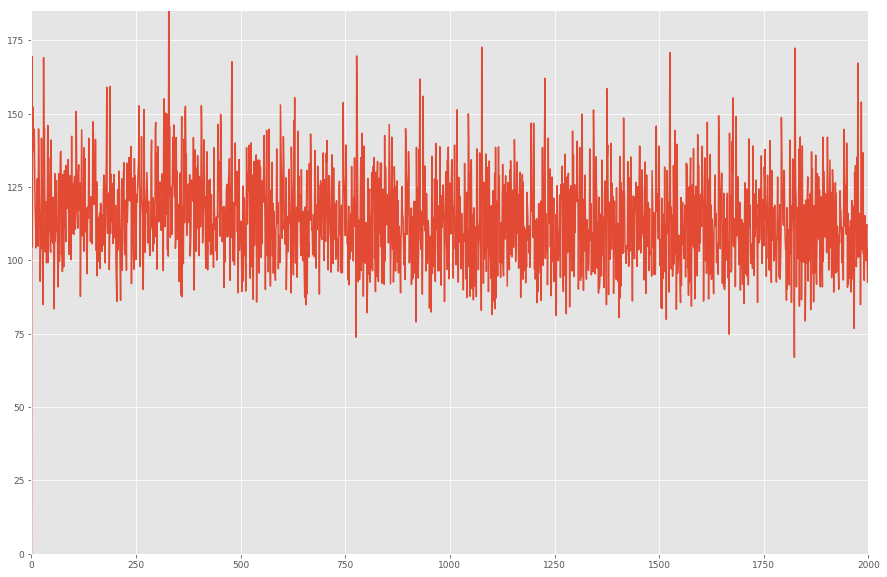

In [28]:
cost_history = np.empty(shape=[1],dtype=float)
with tf.Session() as session:
    tf.global_variables_initializer().run()

    for itr in range(training_iterations):    
        offset = (itr * batch_size) % (train_y.shape[0] - batch_size)
        batch_x = train_x[offset:(offset + batch_size), :, :, :]
        batch_y = train_y[offset:(offset + batch_size), :]
        
        _, c = session.run([optimizer, cross_entropy],feed_dict={X: batch_x, Y : batch_y})
        cost_history = np.append(cost_history,c)
    
    print('Test accuracy: ',round(session.run(accuracy, feed_dict={X: test_x, Y: test_y}) , 3))
    fig = plt.figure(figsize=(15,10))
    plt.plot(cost_history)
    plt.axis([0,training_iterations,0,np.max(cost_history)])
    plt.show()
    

In [30]:
print ("cost_history:", type(cost_history), cost_history.shape)

cost_history: <class 'numpy.ndarray'> (2001,)


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


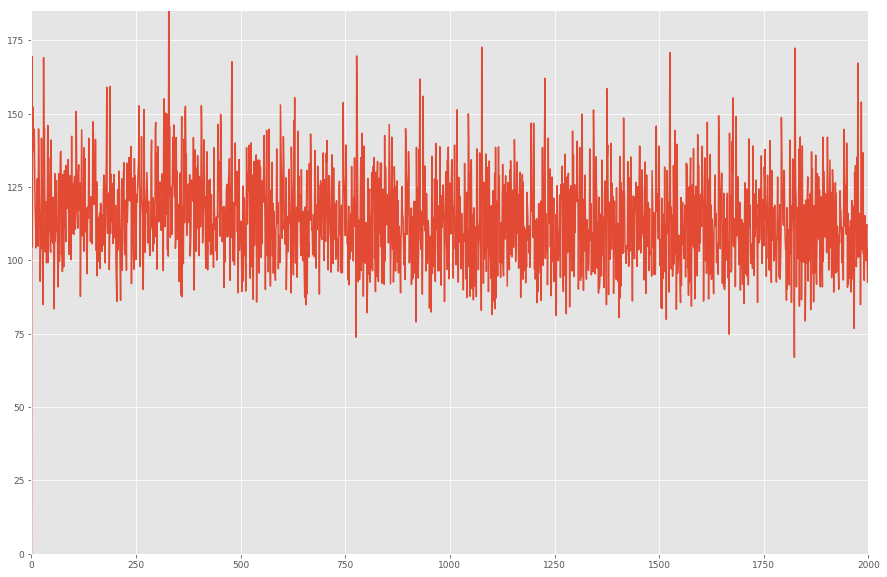

In [33]:
fig = plt.figure(figsize=(15,10))
plt.plot(cost_history)
plt.axis([0,training_iterations,0,np.max(cost_history)])
plt.show()